In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '/Users/ivan.barrera/Documents/GitHub/ivn_datascience/utils')
from utils_EDA import *
from utils_corr import *
from utils_model_interp import *

In [2]:
df = pd.read_csv('train.csv')
df['was_alone'] = True
df.loc[(df.SibSp + df.Parch >0),'was_alone'] = False
df['num_family'] = df.SibSp + df.Parch
df['last_name'] = df.Name.str.split(',').str[0]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
was_alone      891 non-null bool
num_family     891 non-null int64
last_name      891 non-null object
dtypes: bool(1), float64(2), int64(6), object(6)
memory usage: 98.4+ KB


In [4]:
# Too many null values in Cabin
# Some null values on sex -> Maybe inputation with another null category

In [5]:
cat_cols = ['Sex','was_alone','Embarked']
num_cols = ["Age",'SibSp','Parch','Fare', 'num_family']
ord_cols = ["Pclass"]

# EDA

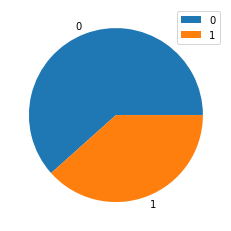

In [6]:
gr = df.groupby('Survived').PassengerId.count()
plt.pie(gr, labels=gr.index)
plt.legend()
plt.show()

### Relationship with target variable

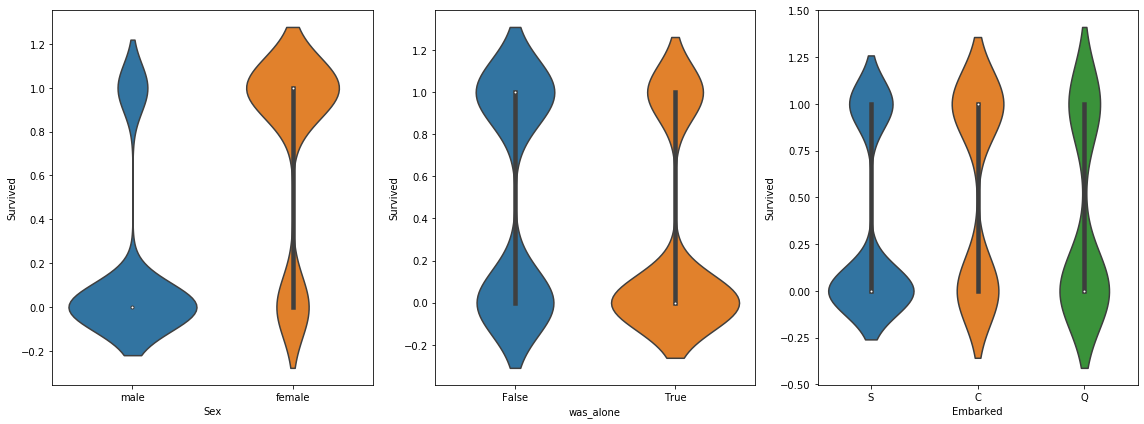

In [7]:
# categorical
fig = plot_cat_violin(df, cat_cols, "Survived", 3, figsize=(16,6))
fig.tight_layout()
plt.show()

In [8]:
pd.crosstab(df.Embarked,df.Survived).apply(lambda r: r/r.sum(), axis=1)

Survived,0,1
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.663043,0.336957


In [9]:
ttest_variables_targetBinary(df[df.Embarked.isin(['C','Q'])], ['Survived'], 'Embarked')

,col,statistic_value,pvalue
0,Survived,2.401059,0.0171


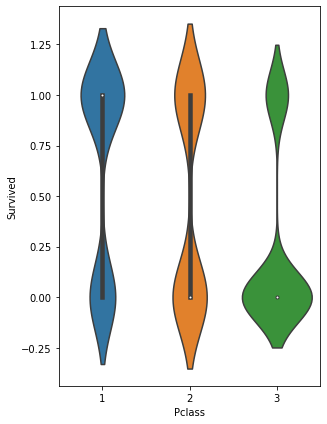

In [10]:
# ordinal
fig = plot_cat_violin(df, ord_cols, "Survived", 4, figsize=(16,6))
fig.tight_layout()
plt.show()

In [11]:
pd.crosstab(df.Pclass,df.Survived).apply(lambda r: r/r.sum(), axis=1)

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


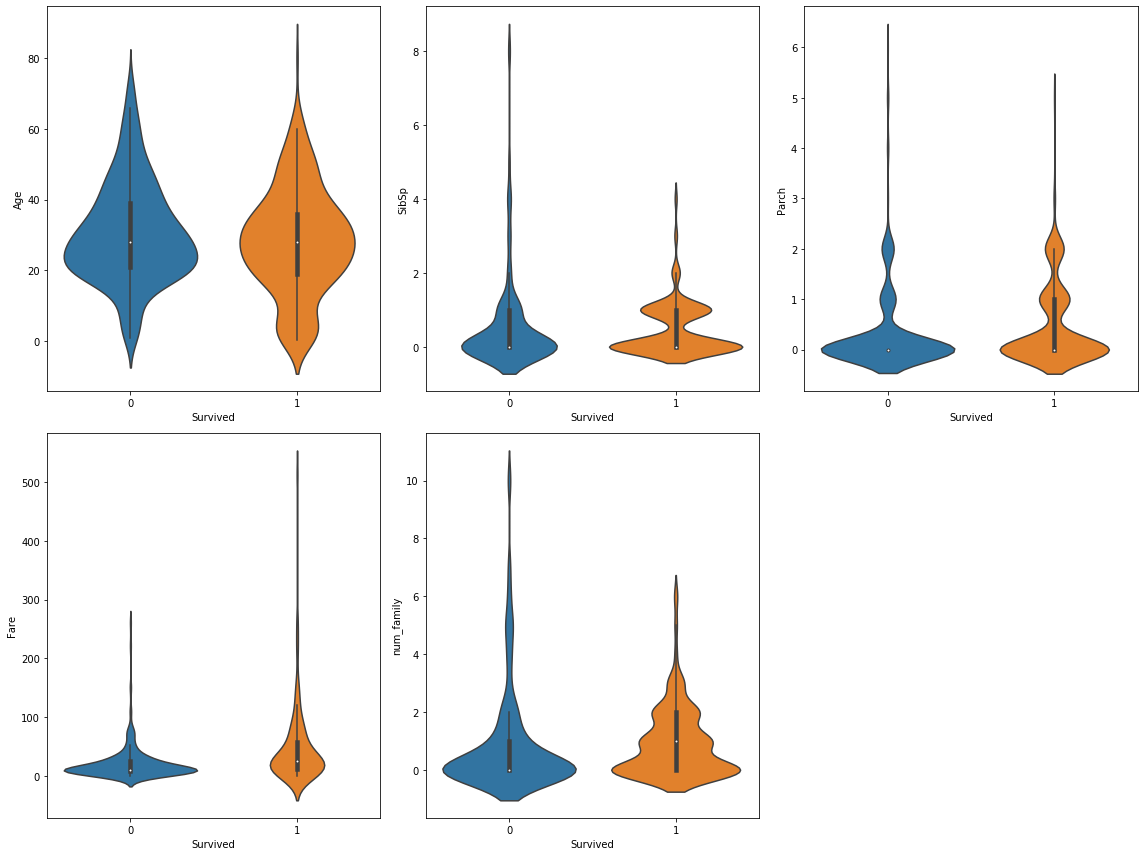

In [12]:
# numerical
fig = plot_num_violin(df, num_cols, "Survived", 3, figsize=(16,12))
fig.tight_layout()
plt.show()

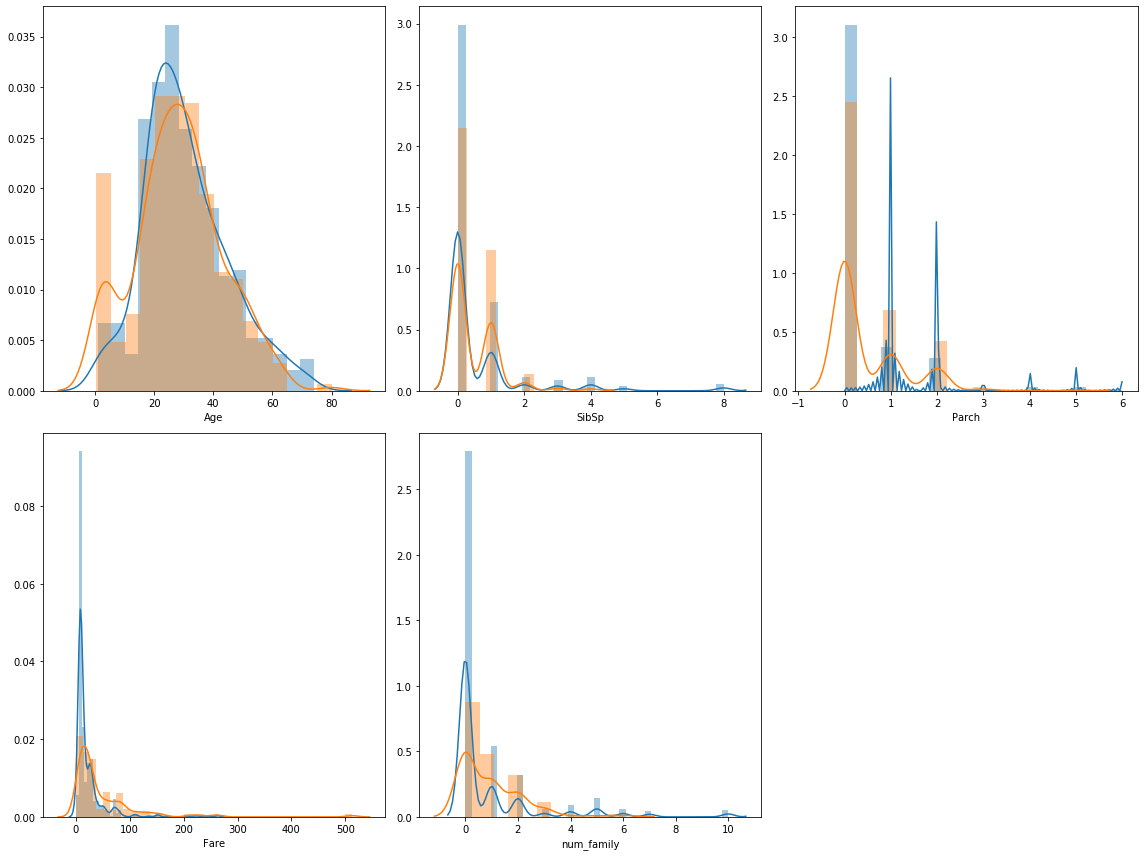

In [13]:
fig = plot_num_hist(df, num_cols, "Survived", 3, figsize=(16,12))
fig.tight_layout()
plt.show()

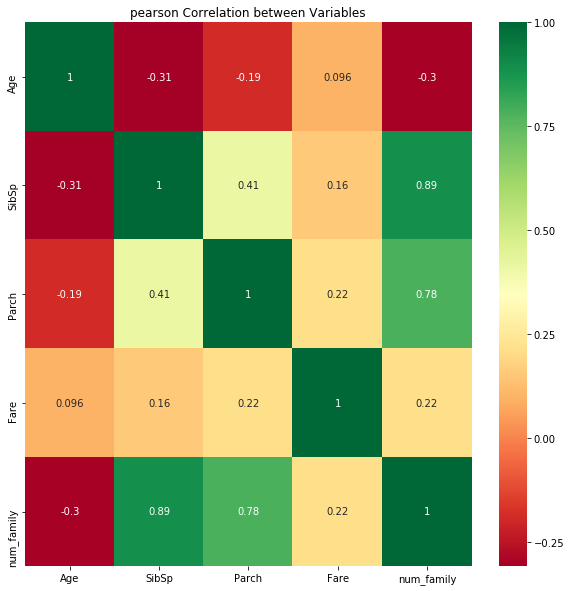

In [14]:
get_numcorr_heatmap(df, num_cols, figsize=(10,10))

In [15]:
df[df.columns[2:]].corr(method='spearman')[ord_cols[0]]

Pclass        1.000000
Age          -0.361666
SibSp        -0.043019
Parch        -0.022801
Fare         -0.688032
was_alone     0.135896
num_family   -0.075698
Name: Pclass, dtype: float64

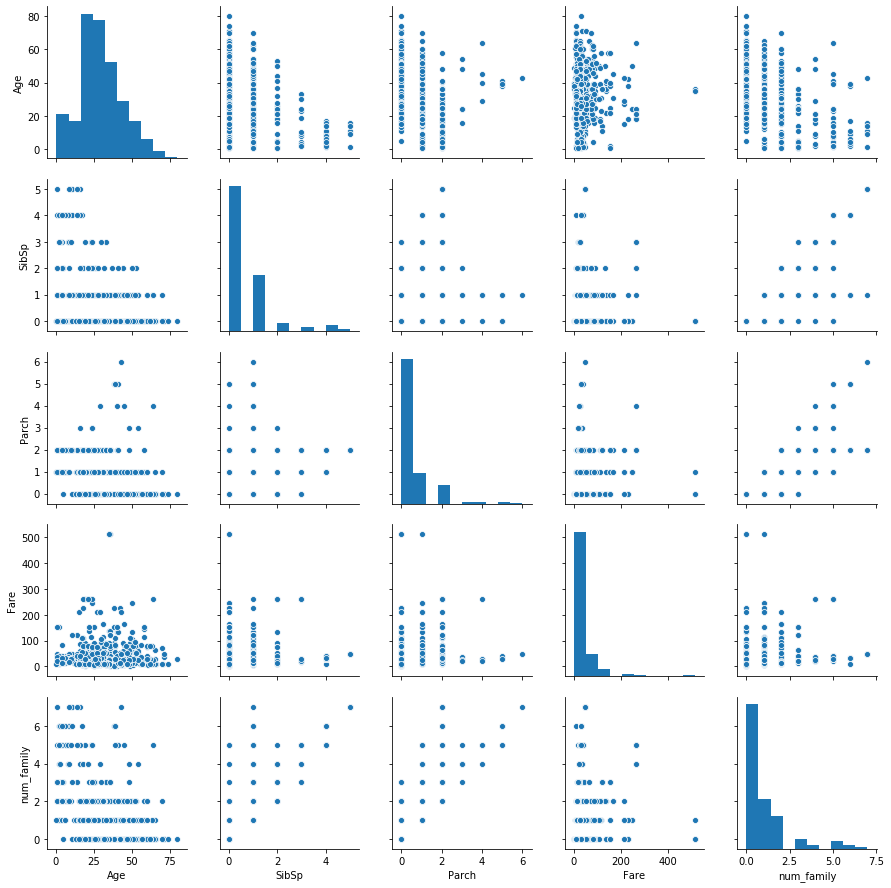

In [16]:
sns.pairplot(df[num_cols].dropna())
plt.show()

In [17]:
pairs = [('Age','SibSp'),('Age','num_family'),('num_family','Fare')]
supected_num_pairs(df, pairs)

,col1,col2,pearsonr,pvalue
0,Age,SibSp,-0.308247,3.509025e-17
1,Age,num_family,-0.301914,1.631842e-16
2,num_family,Fare,0.217138,5.726317e-11


In [18]:
ttest_variables_targetBinary(df, num_cols+ord_cols, 'Survived')

,col,statistic_value,pvalue
0,Age,2.066687,3.912465e-02
1,SibSp,1.053837,2.922439e-01
2,Parch,-2.442020,1.479925e-02
3,Fare,-7.939192,6.120189e-15
4,num_family,-0.496179,6.198911e-01
5,Pclass,10.725263,2.537047e-25


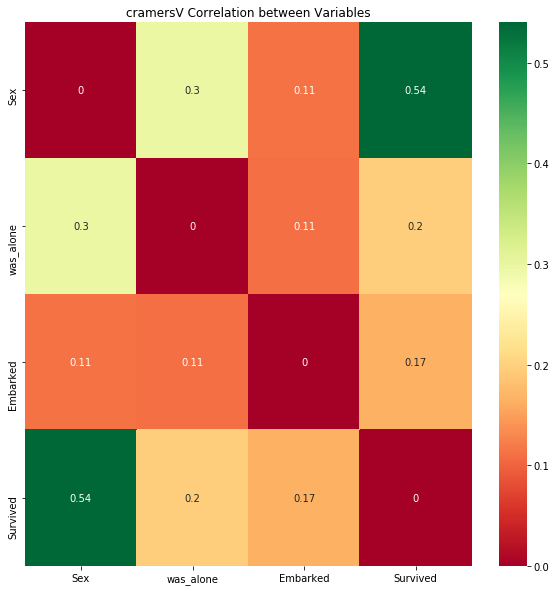

In [19]:
get_catcorr_heatmap(df, cat_cols+['Survived'], method='cramersV')

# Model

### Preprocessing

In [20]:
df['embarked_C'] = False
df.loc[df.Embarked=='C','embarked_C'] = True
cat_features = ['Sex','was_alone','embarked_C','Pclass']
num_features = ["Age",'Parch']
model_df = df.loc[(df.Fare < 300)]
X = model_df[cat_features+num_features]
y = model_df.Survived

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_recall_fscore_support

In [22]:
# Scale numeric fetures
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
# Impute and encode categoric features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unkn')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# Consolidate preprocessing using Column Transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])


### 2D Representation

In [23]:
from sklearn.decomposition import PCA
# Imbalanced original data set
pca = Pipeline(steps=[('preprocessor', preprocessor),
                      ('pca', PCA(n_components=2))])

X_pca_fit = pca.fit_transform(X)

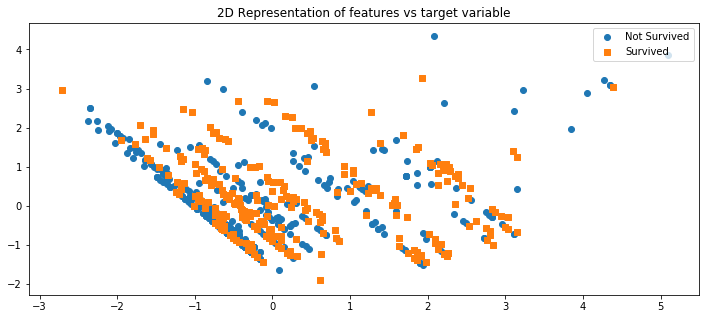

In [24]:
ax = plt.figure(figsize=(12,5))

colors = ['#1F77B4', '#FF7F0E']
markers = ['o', 's']
for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(
        X_pca_fit[y==l, 0],
        X_pca_fit[y==l, 1],
        c=c, label=l, marker=m)
plt.legend(loc='upper right', labels=['Not Survived', 'Survived'])
plt.title('2D Representation of features vs target variable')
plt.show()

In [25]:
# Use a 20% test/train split given the number of saamples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
logit = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

logit.fit(X_train, y_train)
# Get metrics for the model
prec, recall, f1, support = precision_recall_fscore_support(y_train, logit.predict(X_train))
print("model precision: {}, recall: {}, f1-score: {}".format(prec[1], recall[1], f1[1]))
prec, recall, f1, support = precision_recall_fscore_support(y_test, logit.predict(X_test))
print("test precision: {}, recall: {}, f1-score: {}".format(prec[1], recall[1], f1[1]))

model precision: 0.7448559670781894, recall: 0.6830188679245283, f1-score: 0.7125984251968503
test precision: 0.7837837837837838, recall: 0.7837837837837838, f1-score: 0.7837837837837838


/Users/ivan.barrera/anaconda3/envs/general_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:
from sklearn.svm import SVC

In [29]:
svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(probability=True))])

svm.fit(X_train, y_train)
# Get metrics for the model
prec, recall, f1, support = precision_recall_fscore_support(y_train, svm.predict(X_train))
print("model precision: {}, recall: {}, f1-score: {}".format(prec[1], recall[1], f1[1]))
prec, recall, f1, support = precision_recall_fscore_support(y_test, svm.predict(X_test))
print("test precision: {}, recall: {}, f1-score: {}".format(prec[1], recall[1], f1[1]))

model precision: 0.8215962441314554, recall: 0.660377358490566, f1-score: 0.7322175732217573
test precision: 0.8382352941176471, recall: 0.7702702702702703, f1-score: 0.8028169014084507


/Users/ivan.barrera/anaconda3/envs/general_env/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
preprocessor_forest = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_features)])

forest = Pipeline(steps=[('preprocessor', preprocessor_forest),
                      ('classifier', RandomForestClassifier())])

forest.fit(X_train, y_train)
# Get metrics for the model
prec, recall, f1, support = precision_recall_fscore_support(y_train, forest.predict(X_train))
print("model precision: {}, recall: {}, f1-score: {}".format(prec[1], recall[1], f1[1]))
prec, recall, f1, support = precision_recall_fscore_support(y_test, forest.predict(X_test))
print("test precision: {}, recall: {}, f1-score: {}".format(prec[1], recall[1], f1[1]))

model precision: 0.8432432432432433, recall: 0.5886792452830188, f1-score: 0.6933333333333332
test precision: 0.8387096774193549, recall: 0.7027027027027027, f1-score: 0.7647058823529411


/Users/ivan.barrera/anaconda3/envs/general_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Number of trees in random forest
C = [0.01, 0.1, 1, 100]
# Number of features to consider at every split
kernel = ['linear', 'rbf', 'sigmoid']
# Maximum number of levels in tree
gamma = ['scale','auto', 0.01, 0.1]
# Create the random grid
param_grid = {'classifier__C': C,
               'classifier__kernel': kernel,
               'classifier__gamma': gamma
}

svc_cv = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=1)
svc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   17.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [34]:
print(
    "Best C: {C} \n" 
    "Best kernel: {kernel} \n"
    "Best gamma: {gamma}\n".format(
         C=svc_cv.best_params_['classifier__C'],
         kernel=svc_cv.best_params_['classifier__kernel'],
         gamma=svc_cv.best_params_['classifier__gamma']
        
))
print("Best F1-Score: {}".format( svc_cv.best_score_))

Best C: 100 
Best kernel: rbf 
Best gamma: 0.01

Best F1-Score: 0.7163501897434777


## Model Interpretation

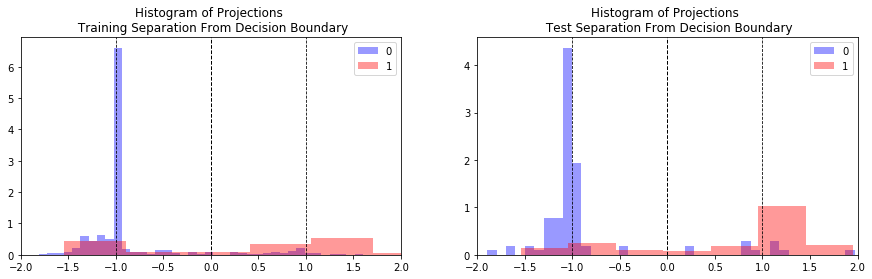

In [35]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

svc_boundaries_binary(svc_cv, X_train, y_train, ax1)
ax1.set_title('Histogram of Projections \n Training Separation From Decision Boundary')
svc_boundaries_binary(svc_cv, X_test, y_test, ax2)
ax2.set_title('Histogram of Projections \n Test Separation From Decision Boundary')

plt.show()

In [36]:
avg_proba = avg_synt_proba(X,y,svc_cv,X.columns, num_features)

In [38]:
# Compared to an average example (Maybe compare to avg noncussed be more meaningful)
x_notSurvived = pd.DataFrame([{'Sex':'male',
                        'was_alone':1,
                        'embarked_C':0,
                        'Pclass':3,
                        'Age': 25,
                        'Parch':0
                       }])
notSurvived_probability = svc_cv.predict_proba(x_notSurvived)[0]
print(notSurvived_probability)

[0.81161558 0.18838442]


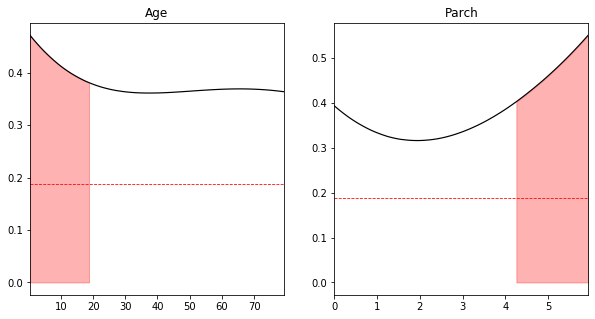

In [39]:
axes = {}
plt.figure(figsize=(10,5))
# plt.suptitle('SVM Model Sensitivity Analysis By Feature')
PLOT_COLUMNS = 2
# Set ranges where there is change
critical_ranges = {
    'Age':0.38,
    'Parch': 0.4
}

for (i, key) in enumerate(num_features):
#for (i, key) in enumerate(avg_proba):
    # Only plot for numerical values
    if len(axes) < i + 1:
        # If axis do not exists, create axis
        ax1 = plt.subplot2grid((1, PLOT_COLUMNS), (0,i))
        axes[key] = ax1
    else:
        # Get axes from stored axes
        ax1 = axes[key]
    # Get probability of survival ([1] == Survived)
    avg_proba[key][1].plot(ax=ax1, color='black', linewidth=1.2)
    ax1.set_title(key)
    # Set Horizontal line with not survived probability
    ax1.axhline(y=notSurvived_probability[1], linestyle='dashed', linewidth=0.8, color='red')
    # Plot critical values shadow
    ## Get index for critical values
    critical_index = avg_proba[key][1] > critical_ranges[key]
    critical_values = avg_proba[key][critical_index][1].index.tolist()
    critical_y = avg_proba[key][critical_index][1].tolist()
    ax1.fill_between(x=critical_values,y1=critical_y, color='r', alpha=0.3, interpolate=True) 

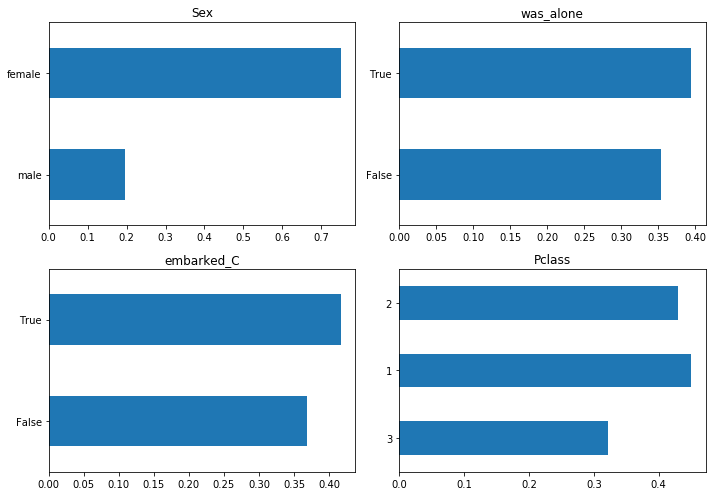

In [40]:
plt.figure(figsize=(10,7))
PLOT_COLUMNS = 2
PLOT_ROWS = int(len(cat_features)/PLOT_COLUMNS)
for i, key in enumerate(cat_features):
    ax1 = plt.subplot2grid((PLOT_ROWS, PLOT_COLUMNS), (int(i/PLOT_COLUMNS),i%PLOT_ROWS))
    avg_proba[key][1].plot(kind='barh', ax=ax1)
    ax1.set_title(key)
    #ax1.axvline(y=mean_probability[1], linestyle='dashed', linewidth=0.8, color='red')
plt.tight_layout()

## Final Test calculation

In [21]:
kaggle_test = pd.read_csv('test.csv')
kaggle_test['was_alone'] = True
kaggle_test.loc[(kaggle_test.SibSp + kaggle_test.Parch >0),'was_alone'] = False
kaggle_test['num_family'] = kaggle_test.SibSp + kaggle_test.Parch
kaggle_test['last_name'] = kaggle_test.Name.str.split(',').str[0]
kaggle_test['embarked_C'] = False
kaggle_test.loc[kaggle_test.Embarked=='C','embarked_C'] = True

In [22]:
kaggle_test['Survived'] = svc_cv.predict(kaggle_test[num_features+cat_features])
kaggle_test[['PassengerId','Survived']].to_csv('titanic_submition.csv', index=False)